# CMAQ to TROPOMI comparison

In [1]:
%matplotlib inline

In [2]:
import copy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature

from cartopy_cmaqfile import cmaqfile

In [3]:
workdir = './'
data_dir = f'{workdir}/data'

## ocean mask

In [4]:
ocnf = f'{data_dir}/oceanmask/12US1_surf.ncf'
ocn = xr.open_dataset(ocnf)
# 1 over land; NaN elsewhere; set threshold of 0.5 (i.e., mask if ocean > 0.5 grid cell area)
ocn_mask = xr.where(ocn['OPEN']>0.5, np.full(ocn['OPEN'].shape, np.nan), np.ones(ocn['OPEN'].shape)).squeeze().values
ocn.close()

## VCD files

In [5]:
cases = ['CRACMM1', 'CRACMM2']
indir = f'{data_dir}/tropomi'
vcd = {case: xr.open_dataset(f'./{indir}/tropomi_hcho_seasonal_mean_2019_{case}.nc') for case in cases}

## CMAQ grid projection info

In [6]:
gridcro_fn = f'{data_dir}/gridcro/GRIDCRO2D_20190101.nc4'
gridcro = xr.open_dataset(gridcro_fn)
gridcro = cmaqfile(gridcro)
Xcorners, Ycorners = gridcro.getXYcorners()
cmaqproj = gridcro.getCMAQproj()

## plot helper functions and settings

In [7]:
def txt_annot(Z, fmt='.1f'):
    txt = f'{Z.mean():{fmt}} ({Z.min():{fmt}}, {Z.max():{fmt}})'
    plt.annotate(txt, xy=(0, -.08), xycoords='axes fraction')

In [8]:
def axis_fix(ax):
    ax.coastlines(lw=.25)
    ax.add_feature(cfeature.STATES, lw=.25)
    ax.add_feature(cfeature.BORDERS, lw=.25)
    ax.set_facecolor('grey')

In [9]:
plt.rcParams.update({'font.size': 10})

## summer averages

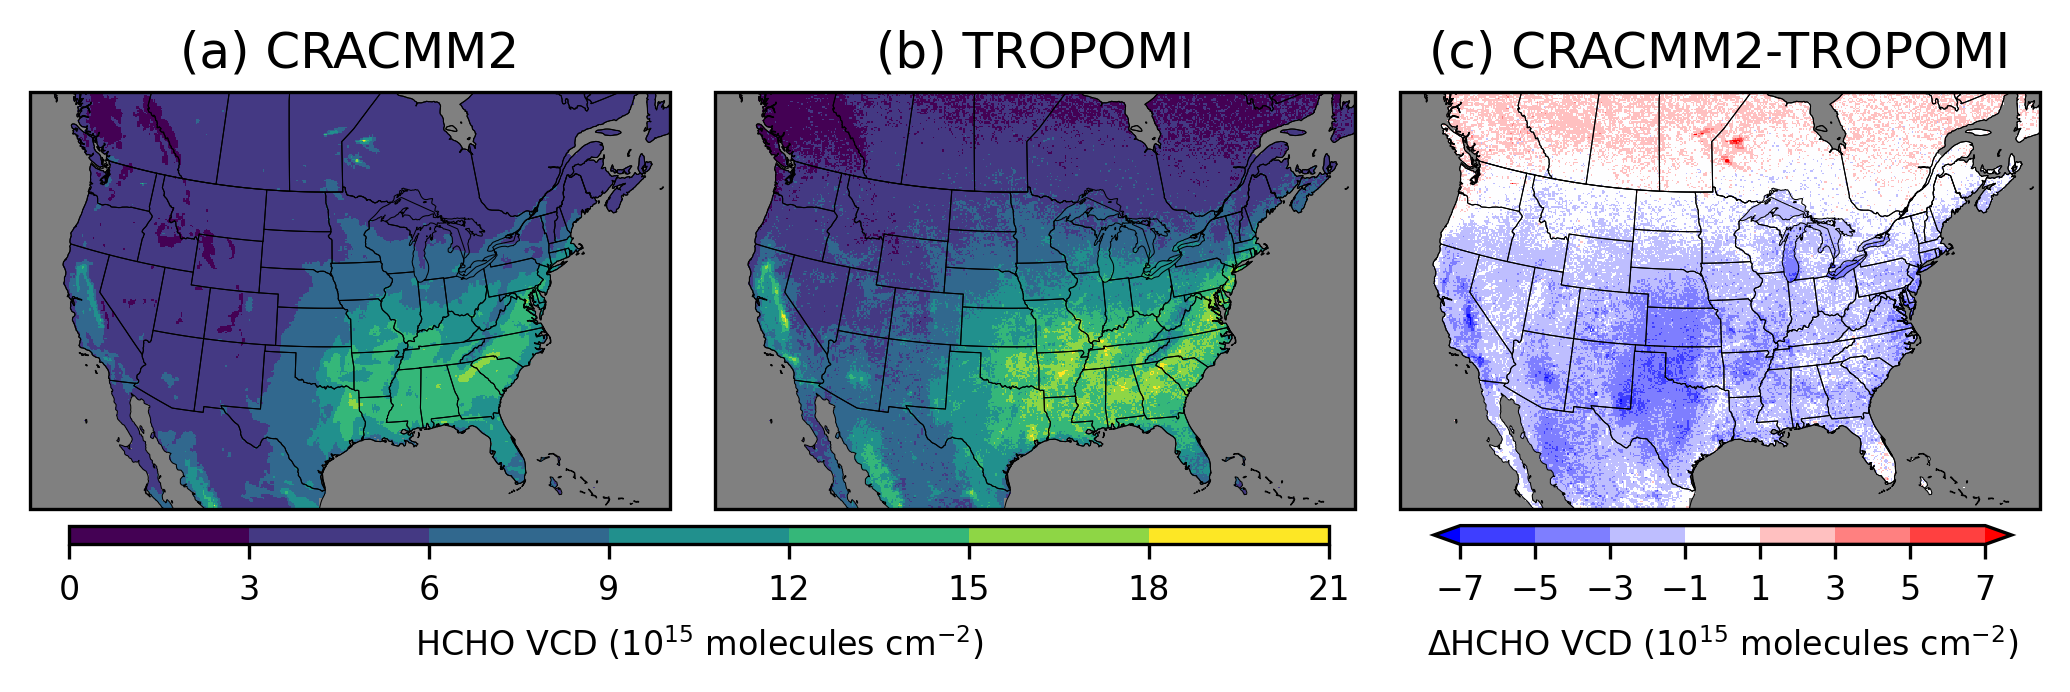

In [10]:
conv_fac = 6.02214e+23/1e+4/1e+15 # convert mol/m2 to 10^15 molecule/cm2
cbarlabel = 'HCHO VCD (10$^{15}$ molecules cm$^{-2}$)'

fig = plt.figure(figsize=(7, 2.5), dpi=300)

season = 'JJA'
vcd_cracmm2 = vcd['CRACMM2']['VCDFORM_CMAQ'].sel(season=season).load()*ocn_mask*conv_fac
vcd_tropomi2 = vcd['CRACMM2']['VCDHCHO_TOMI_CMAQ_gt8scaleup'].sel(season=season).load()*ocn_mask*conv_fac

cmap = 'viridis'
bounds = np.arange(0., 21.01, 3.)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

# CRACMM2
ax1 = fig.add_subplot(131, projection=cmaqproj)
Z1 = vcd_cracmm2
p1 = ax1.pcolormesh(
    Xcorners,
    Ycorners,
    Z1,
    cmap=cmap,
    norm=norm
)
# txt_annot(Z1, fmt='.3f')
axis_fix(ax1)
ax1.set_title('(a) CRACMM2')

# TROPOMI
ax2 = fig.add_subplot(132, projection=cmaqproj)
Z2 = vcd_tropomi2
p2 = ax2.pcolormesh(
    Xcorners,
    Ycorners,
    Z2,
    cmap=cmap,
    norm=norm
)
# txt_annot(Z2, fmt='.3f')
axis_fix(ax2)
ax2.set_title('(b) TROPOMI')

# CRACMM2 - TROPOMI
ax3 = fig.add_subplot(133, projection=cmaqproj)
Z3 = vcd_cracmm2 - vcd_tropomi2
norm_delta3 = mcolors.BoundaryNorm(boundaries=np.arange(-7., 7.01, 2.), ncolors=256, extend='both')
p3 = ax3.pcolormesh(
    Xcorners,
    Ycorners,
    Z3,
    cmap='bwr',
    norm=norm_delta3
)
# txt_annot(Z3, fmt='.3f')
axis_fix(ax3)
ax3.set_title('(c) CRACMM2-TROPOMI')

plt.tight_layout()

# colorbars
# CRACMM2
cax = fig.add_axes([.04, .175, 0.6, .025])
cbar_props = dict(orientation='horizontal')
cbar = plt.colorbar(p1, cax=cax, **cbar_props)
cbar.set_label(cbarlabel, size=8)
cbar.ax.tick_params(labelsize=8)
# CRACMM2-TROPOMI
cax_delta3 = fig.add_axes([.69, .175, .275, .025])
cbar_props_delta3 = dict(orientation='horizontal')
cbar_delta3 = plt.colorbar(p3, cax=cax_delta3, **cbar_props_delta3)
cbar_delta3.set_label(f'$\Delta${cbarlabel}', size=8)
cbar_delta3.ax.tick_params(labelsize=8)

fig.savefig('figures/fig04.tiff')